# 12:30 section Team 6:

- Johara Morovati
- Ka Wa (Leon) Man
- Pushin Huang
- Shui Yu

# Summary

## English Description of Problem

- **Problem:** How to incorporate departments' preference scores into the current class timeslot scheduling process and reduce mismatch between departments'preferences and assigend timeslots


- **Objective:** Maximum the total departments' preference scores, meanwhile promoting the equality of departments' preferences


- **Decision Variables:** $a_{dtrc}$ :  if department $d$ takes up a given timeslot $t$ in a given classroom $r$ on a day of the weekday $c$. $a_{dtrc} \in \text{Binary}$

# Abstract Formulation

## Data:

- $D$: set of Department. 
    - $D \in \{\text{BUCO, DSO, FBE, ACCT, MOR, MKT, BAEP}\}$
- $C$: set of weekday. 
    - $C \in \{1,2,3,4,5\}$ 
- $T$: set of timeslots of a teaching day. 
    - $T \in \{8:00-9:30,9:30-11:00,11:00 - 12:30,\cdots,6:30 - 21:30\} $
- $R$: set of rooms in JKP building. 
    - $R \in \{102, 104, 110, 112, 202, 204, 210, 212\} $
- $m_{d}$: total number of hours a department teaches in a semester 
- $p_{dtc}$ : the percentage of professors from each department $d$ who prefer to teach on timeslot $t$ on weekday $c$
    - $p_{dtc} \in\{0,...,100\}$
- $b_r$: whether a classroom $r$'s capacity is greater than 77 (big classroom)
- $h_{t}$: the number of hours in a particular timeslot, either 1.5 or 3 (night timeslot)

## Decision variables:

- $a_{dtrc}$ :  if department $d$ takes up timeslot $t$ in classroom $r$ on weekday $c$. (Binary)

## Auxiliary variables: 

- $L$: the lower bound of the the total preference score of each department. (Continuous)
- $U$: the upper bound of the the total preference score of each department. (Continuous)

## Objective and constraints:

$$\begin{aligned}
\text{Maximize:} && \sum_{d \in D}\sum_{t \in T}\sum_{r \in R}\sum_{c \in C} a_{dtrc} * p_{dtc} - (U - L) \\
\text{Subject to:} && \\
\text{(MW, TTh)} && a_{dtrc} &= a_{dtr(c+2)}  & \text{For each $d \in D$, $c \in \{1,2\}$, $r \in R$, $t \in T/\{6:30 - 21:30\}$.}\\
\text{(Full Arrangement)} && \sum_{d \in D}a_{dtrc} &\le 1 & \text{For each $c \in C$, $r \in $R, $t \in T$. }\\
\text{(At least 1 big room/dept)} && \sum_{t \in T}\sum_{r \in R}\sum_{c \in C} b_r  a_{dtrc} &\ge 1  & \text{For each $d \in D$.}\\
\text{(Preference balance)} && L \le \frac{\sum_{c \in C}\sum_{r \in R}\sum_{t \in T} a_{dtrc}p_{dtc}}{\sum_{c \in C}\sum_{t \in T} p_{dtc}} & \le U & \text{For each $d \in D$.}\\
\text{(Hours demand)} && \sum_{c \in C}\sum_{r \in R}\sum_{t \in T}h_{t} a_{dtrc} & \ge m_{d} & \text{For each $d \in D$.}\\
\text{(Binary)} && a_{dtrc} &\in \{0, 1\} & \text{For all $d$, $t$, $r$, $c$.}\\
\end{aligned}$$

# Gurobi Coding

 - Be careful, the Prefereoce Score in 'DSO570_data_template_v2.xlsx' data we used was just randomly generated by using rand() function in excel, for testing purpose only
 
 - In the later part, we will use the historical data of actual time schedule from 2015 - 2019 to simulate a more realistc picture based on the historical data

## Import data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import GRB, Model 

inputFile = 'Sample_Input.xlsx'

# Classroom settings - R
classroom = pd.read_excel(inputFile,sheet_name='classroom - Pr',index_col = 0)

# The number of hours defined for each timeslot - ht
hours = pd.read_excel(inputFile,sheet_name='hours - ht',index_col = 0)

# How many hours to teach in a week
md =  pd.read_excel(inputFile,sheet_name='md',index_col = 0)

# Departments Preference Scores
department_dict = {i:pd.read_excel(inputFile,sheet_name=i,index_col = 0)for i in md.index}

# Set of department
department = md.index

# Set of weekday
weekday = department_dict['BUCO'].columns

# Set of timeslots
timeslots = department_dict['BUCO'].index[1:]

# Set of classrooms
classroom_set = classroom.index

# Whether a classroom is a big or small classrooms
br = classroom.Big

# hour to teach
ht = md['hours to teach in a semester']

## Gurobipy Coding

In [2]:
import pandas as pd
from gurobipy import Model, GRB

def optimize(inputFile,outputFile):
    """Description: The function for do class scheduling, which can 
           maximize overall departments' preference scores, meanwhile promoting fairness
    Arguments
        1. InputFile: the path contains the Excel file in which data is stored for optimization
        2. OutputFile: the path customized and defined by users to produce the optimal Class Schedule
    
    """
    
    # Classroom settings - R
    classroom = pd.read_excel(inputFile,sheet_name='classroom - Pr',index_col = 0)

    # The number of hours defined for each timeslot - ht
    hours = pd.read_excel(inputFile,sheet_name='hours - ht',index_col = 0)

    # How many hours to teach in a week
    md =  pd.read_excel(inputFile,sheet_name='md',index_col = 0)

    # Departments Preference Scores
    department_dict = {i:pd.read_excel(inputFile,sheet_name=i,index_col = 0)for i in md.index}

    # Set of department
    department = md.index

    # Set of weekday
    weekday = department_dict['BUCO'].columns

    # Set of timeslots
    timeslots = department_dict['BUCO'].index[1:]

    # Set of classrooms
    classroom_set = classroom.index

    # Whether a classroom is a big or small classrooms
    br = classroom.Big

    # hour to teach
    ht = md['hours to teach in a semester']

    # Initialize the Models
    mod = Model()

    # Add variables - a{dtrc}
    X = mod.addVars(department,timeslots,classroom_set,weekday,lb = 0,vtype = GRB.BINARY)
    U = mod.addVar(lb = 0)
    L = mod.addVar(lb = 0)

    ## Objective Function
    mod.setObjective(sum(X[d,t,r,c]*department_dict[d].loc[t,c] for d in department for t in timeslots for c in weekday for r in classroom_set) - (U - L),\
                     sense=GRB.MAXIMIZE
    )

    ## Constraints - MW,TH
    for d in department:
        for t in timeslots[:-1]:
            for c in weekday[:2]:
                for r in classroom_set:
                    mod.addConstr(X[d,t,r,c] == X[d,t,r,c+2], name =f'MWTH_{d}{t}{r}{c}')

    ## Constraints - full arrangement 
    for t in timeslots:
        for c in weekday:
            for r in classroom_set:
                mod.addConstr(sum(X[d,t,r,c] for d in department) <=1, name = f'full_arrange_{d}_{t}_{r}_{c}')

    ## Constraint - At least one big room for each department
    for d in department:
        mod.addConstr(sum(X[d,t,r,c] * br[r] for t in timeslots for r in classroom_set for c in weekday )>=1, name = f'full_arrange_{d}' )

    ## Constraint - Preference Balance -  Lower Bound
    for d in department:
        nominator = sum(X[d,t,r,c]*department_dict[d].loc[t,c] for t in timeslots for r in classroom_set for c in weekday)

        denominator = sum(department_dict[d].loc[t,c] for t in timeslots for r in classroom_set)

        mod.addConstr((nominator/denominator) >= L,name = f'Preference_Bal_L_{d}')

    ## Constraint - Preference Balance -  Upper Bound    
    for d in department:
        nominator = sum(X[d,t,r,c]*department_dict[d].loc[t,c] for t in timeslots for r in classroom_set for c in weekday)

        denominator = sum(department_dict[d].loc[t,c] for t in timeslots for r in classroom_set)

        mod.addConstr((nominator/denominator) <= U,name = f'Preference_Bal_U_{d}')

    ## Constraint - hour demands
    for d in department:
        mod.addConstr(sum(X[d,t,r,c]*hours.loc[t,c] for t in timeslots for r in classroom_set for c in weekday )>=ht[d], name = f'hour_demand_{d}')

    # build up a storage dataframe
    index_1 = pd.MultiIndex.from_product([weekday,timeslots],
                                        names=['Weekday ','Timeslot']
                                       )
    # Create an empty dataframe to store the optimized outputs from the model
    schedule = pd.DataFrame(index = index_1, 
                            columns = classroom_set
    )

    # Functionality to perform optimization and print out the results
    mod.setParam('OutputFlag',False)
    mod.optimize()
    print(f'The Optimal Preference Scores is: {mod.ObjVal}')

    # Get the output
    for d in department:
        for t in timeslots:
            for c in weekday:
                for r in classroom_set:
                    # only select the value of a variable equal to 1.0
                    if X[d,t,r,c].x:
                        schedule.loc[(c,t),r] = d
    
    # to get a clean, organized and concise timeslot timetable
    df_storage = []
    idx = pd.IndexSlice
    for c in weekday:
        if c in [1,2]:
            df_temp = schedule.loc[idx[c,timeslots[:-1]],:].reset_index()
            if c == 1:
                df_temp.loc[:,'Weekday '] = 'Mon & Wed'
            elif c == 2:
                df_temp.loc[:,'Weekday '] = 'Tue & Thur'
            df_storage.append(df_temp) 

        if c in [1,2,3,4]:
            df_temp = schedule.loc[idx[c,timeslots[-1]],:].to_frame().T.reset_index()

            df_temp.columns = ['Weekday ', 'Timeslot', 102, 104, 110, 112, 202, 204, 210, 212]
            if c == 1:
                df_temp.loc[:,'Weekday '] = 'Mon'
            elif c == 2:
                df_temp.loc[:,'Weekday '] = 'Tue'
            elif c == 3:
                df_temp.loc[:,'Weekday '] = 'Wed'
            elif c == 4:
                df_temp.loc[:,'Weekday '] = 'Thur'     
            df_storage.append(df_temp)
        if c in [5]:
            df_temp = schedule.loc[idx[c,timeslots[:]],:].reset_index()
            df_temp.loc[:,'Weekday '] = 'Fri'
            df_storage.append(df_temp)

    # to sort the table in the order of ["Mon & Wed", "Mon", "Wed", "Tue & Thur", "Tue", "Thur", "Fri"]
    df_schedule = pd.concat(df_storage, axis = 0)      
    orders = ["Mon & Wed", "Mon", "Wed", "Tue & Thur", "Tue", "Thur", "Fri"]
    idx_ordered = pd.Categorical(df_schedule['Weekday '].values, categories=orders,
              ordered=True)
    
    df_schedule['Weekday '] = idx_ordered
    
    # define the timeslot order
    orders2 = timeslots
    idx_ordered2 = pd.Categorical(df_schedule['Timeslot'].values, categories=orders2,
              ordered=True)
    df_schedule['Timeslot'] = idx_ordered2
    
    # sort values by 'Weekday ','Timeslot'
    df_schedule.sort_values(by = ['Weekday ','Timeslot'],ascending=True,inplace = True)
    df_schedule.set_index(['Weekday ','Timeslot'],inplace = True)
    
    # Create an output file
    writer = pd.ExcelWriter(outputFile)
    df_schedule.to_excel(writer, sheet_name = 'Class Schedule', index = True)
    writer.save()

# test the function to see if it will work
inputFile = 'Sample_Input.xlsx'
outputFile = 'Sample_Output.xlsx'
optimize(inputFile,outputFile)

Using license file /Users/pushin/gurobi.lic
Academic license - for non-commercial use only
The Optimal Preference Scores is: 159.984375


# Visualization

## Import Data For Simulation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import data for simulation
weekday_count = pd.read_excel('Sample_Input.xlsx',sheet_name = 'Weekday Count').astype('int64')
Timeslot_count = pd.read_excel('Sample_Input.xlsx',sheet_name = 'Timeslot Count',index_col = 0).astype('int64')

In [4]:
# showt the dataframe - weekday_count
weekday_count

,Weekday,Count
0,1,51365
1,2,36688
2,3,43570
3,4,38794
4,5,13580


In [5]:
# show the dataframe - Timeslot_count
Timeslot_count

,Count
Timeslot,
800-930,32698
930-1100,27476
1100-1230,40244
1230-1400,27562
1400-1530,19567
1530-1700,12273
1700-1830,13876
1830-2130,10299


## Auxiliary Function for Plotting

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.
    Arguments:
        1. ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        2. spacing (int): The distance between the labels and the bars.
    """
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'
        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'
        # Use Y value as label and format number with one decimal place
        label = "{}".format(str(int(y_value)))
        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va = va,                    # Vertically align label differently for
            size = 12                    # fontsize
        )   

## Weekday Distribution from 2015 - 2019 (7 departments' classes in JKP only)

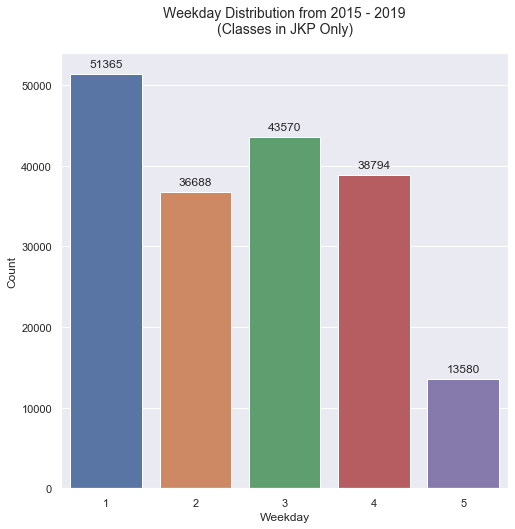

In [7]:
# Control the properties of the chart
plt.rcParams.update({'font.size': 14,
                     'ytick.labelsize':12,
                     'xtick.labelsize':12,
                    }
                   )
# Set the style to darkgrid
sns.set(style="darkgrid")

# Initialize the chart
plt.figure(figsize = (8,8))

# Plot the chart
ax = plt.gca()
plt.title('Weekday Distribution from 2015 - 2019\n(Classes in JKP Only)',
          fontsize = 14,
          pad = 20 
         )
sns.barplot(x = 'Weekday',y = "Count",data = weekday_count,ax = ax)
add_value_labels(ax, spacing=5)
plt.show()

## Timeslot Distribution from 2015 - 2019 (7 departments' classes in JKP only)

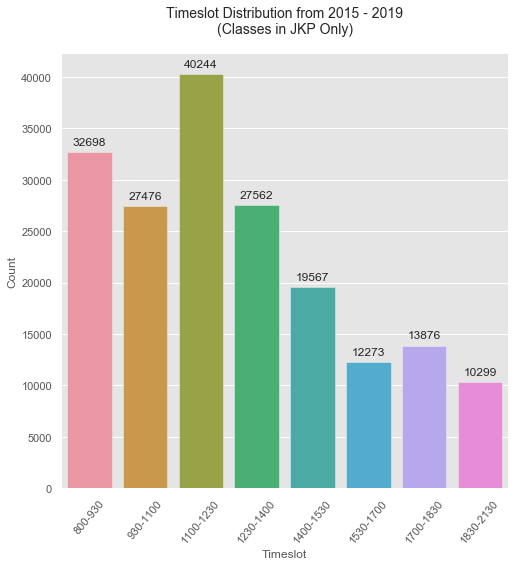

In [8]:
# Initialize the figure
plt.figure(figsize = (8,8))
plt.style.use('ggplot')
ax = plt.gca()

# Plot the chart 
sns.barplot(x = 'Timeslot',
            y = "Count",
            data = Timeslot_count.reset_index(),
            ax = ax)

# Control the Properties of the Chart
plt.title('Timeslot Distribution from 2015 - 2019\n(Classes in JKP Only)',
          fontsize = 14,
          pad = 20
         )

plt.xticks(rotation = 50)
add_value_labels(ax, spacing=5)
plt.show()

# Probability of Timesslot Distribution (Classes in JKP Only)

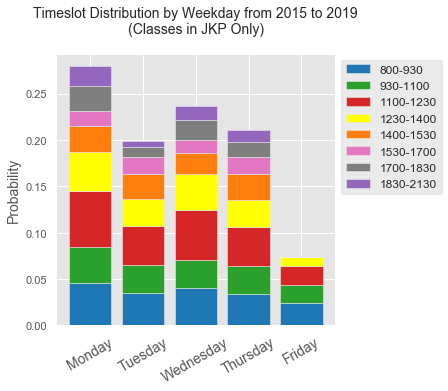

In [9]:
import pandas as pd
import matplotlib.pyplot as plot

colors = ['tab:blue','tab:green','tab:red','yellow','tab:orange','tab:pink','tab:grey','tab:purple']

plt.style.use("ggplot")

# Import Data
dist_slot = pd.read_excel('Sample_Input.xlsx',sheet_name = 'Classroom Probability').set_index('Timeslot').T.reset_index()
dist_slot

cumval=0

# Plot the chart
fig = plt.figure(figsize=(5,5))
for index, col in enumerate(dist_slot.columns[~dist_slot.columns.isin(['index'])]):
    plt.bar(dist_slot["index"], dist_slot[col], bottom=cumval, label=col, color = {colors[index]})
    cumval = cumval+dist_slot[col]

# Control the plot properties 
_ = plt.ylabel("Probability",fontsize = 14)
_ = plt.xticks(rotation=30,fontsize = 14)
ax = plt.gca()
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(labels = ['Monday','Tuesday','Wednesday','Thursday','Friday'])

_ = plt.title('Timeslot Distribution by Weekday from 2015 to 2019\n(Classes in JKP Only)', 
              fontsize = 14,
              pad = 20
             )
_ = plt.legend(fontsize=12, bbox_to_anchor = (1,1))

# Create a simulated data based on the historical records - generate realistic data

## The team does not known department's preferences 
- We presume that when the team does not know preferences scores of a department, they would presume that 50% of all professors in a given department prefer a given timeslot, please view the details of part 2 - Opportunity for Improvement in the report

In [10]:
no_preference_df_MKT = pd.read_excel('Sample_Input.xlsx',sheet_name = 'MKT', index_col = 'weekday')

# As you can see, all the preference score will be assumed to be 0.5 (either select this timeslot 
# or not for a given department)
no_preference_df_MKT.iloc[1:,:]

,1,2,3,4,5
weekday,,,,,
800-930,0.5,0.5,0.5,0.5,0.5
930-1100,0.5,0.5,0.5,0.5,0.5
1100-1230,0.5,0.5,0.5,0.5,0.5
1230-1400,0.5,0.5,0.5,0.5,0.5
1400-1530,0.5,0.5,0.5,0.5,0.5
1530-1700,0.5,0.5,0.5,0.5,0.5
1700-1830,0.5,0.5,0.5,0.5,0.5
1830-2130,0.5,0.5,0.5,0.5,0.5


## Build a simulation function 

In [11]:
from scipy.stats import norm
from scipy import stats
import numpy as np

def simulated_data(inputFile,sheetname):
    """
    the function will be used for simulating the situation when the team know different
    department's preference for different timeslots 
    
    Argument:
        - 1 inputFile - the excel file which contains the empirical probability distribution
        - 2 Sheetname - the sheet name, which contains the empirical probability distribution
    """
    # Import data
    dist_slot = pd.read_excel(inputFile,sheet_name = sheetname,index_col = 0)

    # get the mean and std of the historical data
    mean = dist_slot.values.mean()
    std = dist_slot.values.std()
    
    dict_department_realistc = {}
    for d in department:
        # create a storage dataframe
        df_storage = pd.DataFrame(columns =dist_slot.columns,index = dist_slot.index)
        for c in dist_slot.columns:
            for t in dist_slot.index:
                # get random select a value within the one standard deviation for a given timeslot
                arr = stats.truncnorm.rvs(-1, 1, loc=dist_slot.loc[t,c], scale=std, size=1) 
                # get the cdf - the higher the cdf, the higher preference score for a given timeslot
                probability = norm(mean,std).cdf(arr[0])
                # store the simulated results into a dataframe
                df_storage.at[t,c] = probability

        dict_department_realistc[d] = df_storage
    # return the dataframe with 7 depts's preference scores
    return dict_department_realistc

simulated_data('Sample_Input.xlsx','Classroom Probability')

{'BUCO':                   1         2         3          4           5
 Timeslot                                                      
 800-930    0.986305  0.723159  0.620543   0.611812    0.602953
 930-1100   0.879215  0.806721  0.879327   0.899055    0.404748
 1100-1230  0.940252  0.950153  0.916749    0.65746    0.166589
 1230-1400  0.942733  0.524166  0.970216   0.808619   0.0514629
 1400-1530  0.636814  0.599891  0.294049   0.494094  0.00355021
 1530-1700   0.34553  0.293017  0.347068   0.601298    0.173708
 1700-1830  0.509587  0.264409  0.247188   0.264409     0.16936
 1830-2130  0.203668  0.248687  0.450595  0.0732883    0.204548,
 'DSO':                   1          2         3          4           5
 Timeslot                                                       
 800-930    0.971996   0.800551  0.928346   0.701943    0.290958
 930-1100   0.720849    0.90417  0.749477   0.570229    0.447534
 1100-1230  0.951157   0.965868  0.996318    0.62268    0.161012
 1230-1400  0.70156

## Run simulations to foresee how much preference score can be improved
-  We are going to run 10 times simulation to see how it would be compared with the situation in which the class scheduling team does not know preference scores of all departments

In [12]:
import pandas as pd
from gurobipy import Model, GRB

def optimize_sim(inputFile,simulated_dict):
    """
    Description:
       This function is just used for simulation purpose to know how they the model and known
       preference score can improve overall satisfaction of USC Marshall
    Argument:
        1. inputFile 
        2. simulated_dict: the simulated dctionary which contains simulated preference scores
            of all department, which is created by the function "simulated_data"
    Return:
        - the optimal preference scores
    """
    
    # Classroom settings - R
    classroom = pd.read_excel(inputFile,sheet_name='classroom - Pr',index_col = 0)

    # The number of hours defined for each timeslot - ht
    hours = pd.read_excel(inputFile,sheet_name='hours - ht',index_col = 0)

    # How many hours to teach in a week
    md =  pd.read_excel(inputFile,sheet_name='md',index_col = 0)

    # Departments Preference Scores
    department_dict = simulated_dict

    # Set of department
    department = md.index

    # Set of weekday
    weekday = department_dict['BUCO'].columns

    # Set of timeslots
    timeslots = department_dict['BUCO'].index[1:]

    # Set of classrooms
    classroom_set = classroom.index

    # Whether a classroom is a big or small classrooms
    br = classroom.Big

    # hour to teach
    ht = md['hours to teach in a semester']

    # Initialize the Models
    mod = Model()

    # Add variables - a{dtrc}
    X = mod.addVars(department,timeslots,classroom_set,weekday,lb = 0,vtype = GRB.BINARY)
    U = mod.addVar(lb = 0)
    L = mod.addVar(lb = 0)

    ## Objective Function
    mod.setObjective(sum(X[d,t,r,c]*department_dict[d].loc[t,c] for d in department for t in timeslots for c in weekday for r in classroom_set) - (U - L),\
                     sense=GRB.MAXIMIZE
    )

    ## Constraints - MW,TH
    for d in department:
        for t in timeslots[:-1]:
            for c in weekday[:2]:
                for r in classroom_set:
                    mod.addConstr(X[d,t,r,c] == X[d,t,r,c+2], name =f'MWTH_{d}{t}{r}{c}')

    ## Constraints - full arrangement 
    for t in timeslots:
        for c in weekday:
            for r in classroom_set:
                mod.addConstr(sum(X[d,t,r,c] for d in department) <=1, name = f'full_arrange_{d}_{t}_{r}_{c}')

    ## Constraint - At least one big room for each department
    for d in department:
        mod.addConstr(sum(X[d,t,r,c] * br[r] for t in timeslots for r in classroom_set for c in weekday )>=1, name = f'full_arrange_{d}' )

    ## Constraint - Preference Balance -  Lower Bound
    for d in department:
        nominator = sum(X[d,t,r,c]*department_dict[d].loc[t,c] for t in timeslots for r in classroom_set for c in weekday)

        denominator = sum(department_dict[d].loc[t,c] for t in timeslots for r in classroom_set)

        mod.addConstr((nominator/denominator) >= L,name = f'Preference_Bal_L_{d}')

    ## Constraint - Preference Balance -  Upper Bound    
    for d in department:
        nominator = sum(X[d,t,r,c]*department_dict[d].loc[t,c] for t in timeslots for r in classroom_set for c in weekday)

        denominator = sum(department_dict[d].loc[t,c] for t in timeslots for r in classroom_set)

        mod.addConstr((nominator/denominator) <= U,name = f'Preference_Bal_U_{d}')

    ## Constraint - hour demands
    for d in department:
        mod.addConstr(sum(X[d,t,r,c]*hours.loc[t,c] for t in timeslots for r in classroom_set for c in weekday )>=ht[d], name = f'hour_demand_{d}')

    # Functionality to perform optimization and print out the results
    mod.setParam('OutputFlag',False)
    mod.optimize()

    return mod.ObjVal

## Simulate realistic data for 100 times

In [13]:
# inputFile
inputFile = 'Sample_Input.xlsx'

# set up a list to store all simulated preference scores
preferences_score = []

# simulate 100 times, it may take a while around 1m 30s to run
# the simulation results might be different from time to time, it has randomness
for i in range(100):
    sim_dict = simulated_data(inputFile,'Classroom Probability')
    objval = optimize_sim(inputFile,sim_dict)
    preferences_score.append(objval)

## Visualization of Simulation Results

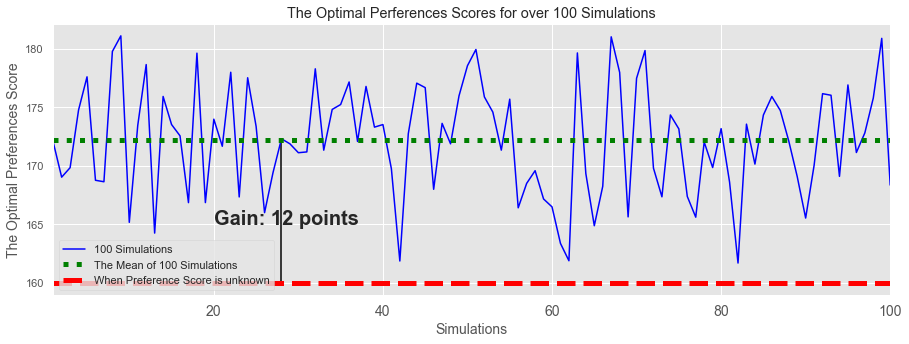

In [14]:
# create a plot
plt.figure()
ax = plt.gca()

# prepare data for plotting
pd.Series(preferences_score, index = np.arange(1,len(preferences_score)+1)).plot(figsize = (15,5), 
                                                                                 color = 'blue',
                                                                                 ax = ax,
                                                                                 label = '100 Simulations'
)

# plotting properties
ax.set_xlabel('Simulations',fontsize = 14)
ax.set_ylabel('The Optimal Preferences Score',fontsize = 14)
ax.set_title('The Optimal Perferences Scores for over 100 Simulations')
ax.set_xticklabels(labels = [int(i) for i in ax.get_xticks()], fontsize = 14)


# plot the the line for the average level of known situation
ax.axhline(np.mean(preferences_score),xmin =0, xmax = 100,linestyle = ':',linewidth = 5,color = 'green', label = 'The Mean of 100 Simulations')

# plot the line for the average level of unknown situation
ax.axhline(159.984375,xmin =0, xmax = 100,linestyle = '--',linewidth = 5,color = 'red',label = 'When Preference Score is unknown')

# plot the distance line between known and unknown situation
ax.vlines(x = 28, ymin =159.984375, ymax = np.mean(preferences_score), color = 'black')
ax.annotate(s = f'Gain: {int(np.mean(preferences_score) - 159.984375)} points',
            xy = (20,165),
            fontsize = 20,
            fontweight = 'bold'
           )
plt.legend(loc = 'best')
plt.show()